In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score

from utils import save_plotly_figure_as_html
from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
from ex_04_my_kmeans import MyKMeans


In [7]:
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_04")
plot_path.mkdir(parents=True, exist_ok=True)


data, labels, exp_ids = get_welding_data(data_path, n_samples=5_000)

## Exercise 4.2: Optimal Cluster Selection

Implement the elbow method to find the optimal number of clusters for the raw time series data using your implement of the kmeans algorithm (MyKMeans).

1. Calculate the distortion (inertia) for different values of k (1 to 10)
2. Plot the results to identify the "elbow point" with matplotlib where adding more clusters produces diminishing returns
3. This will help determine the most appropriate number of clusters for our welding data

KMeans fitting: 100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


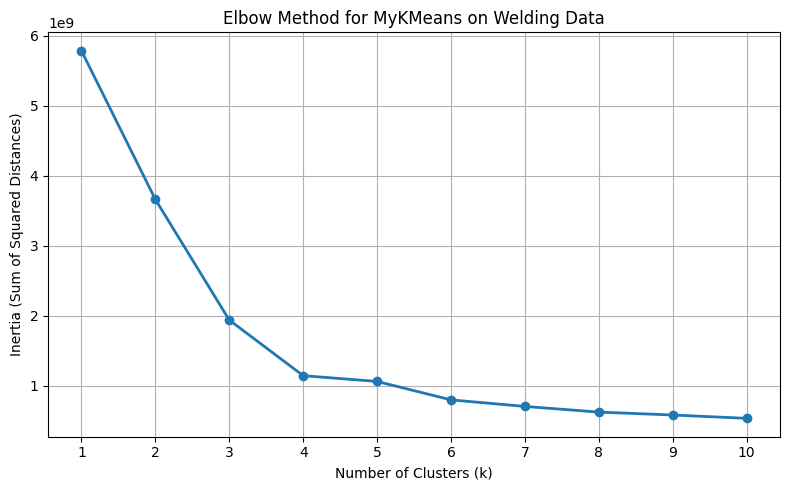

In [8]:
# 1) Flatten 3D time-series into 2D feature matrix once
X_flat = data.reshape(data.shape[0], -1)
assert X_flat.ndim == 2, f"Flattened data must be 2D, got {X_flat.ndim}D"

# 2) Define reusable elbow_data function that expects 2D input
def elbow_data(X, k_range=range(1, 11), distance_metric="euclidean",
               max_iter=50, init_method="kmeans++"):
    """
    Compute inertia values for a range of cluster counts using MyKMeans on 2D data.
    """
    inertias = []
    for k in k_range:
        model = MyKMeans(
            k=k,
            max_iter=max_iter,
            distance_metric=distance_metric,
            init_method=init_method
        )
        model.fit(X)
        inertias.append(model.inertia_)
    return inertias

# 3) Compute inertias for k=1..10
ks = list(range(1, 11))
inertias = elbow_data(X_flat, ks)

# 4) Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, 'o-', linewidth=2, markersize=6)
plt.xticks(ks)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for MyKMeans on Welding Data')
plt.grid(True)
plt.tight_layout()
# Save and show
plt.savefig(plot_path / 'elbow_method_my_kmeans.png', dpi=300)
plt.show()


## Exercise 4.3: Clustering with MyKMeans

### Based on the elbow curve above, explain your choice of k:

1. What does the shape of the elbow curve tell you about the underlying data structure?
2. Why did you select this specific number of clusters?
   - Consider the plot and the elbow method to justify your choice
   - How might this choice affect the interpretability of the resulting clusters?

### KMeans with euclidean distance and dtw distance
1. run K means with you selected k 


In [10]:
# Exercise 4.3 – Cluster Analysis and Comparison

# Based on the elbow curve from Exercise 4.2, we select k=3 as the optimal number of clusters.
# This is the point where the inertia (sum of squared distances) shows a significant drop before leveling off,
# indicating that adding more clusters beyond this point yields diminishing returns.

# 1. Run KMeans with Euclidean Distance
model_euclidean = MyKMeans(
    k=3,
    distance_metric="euclidean",
    init_method="kmeans++",
    max_iter=100
)
labels_euclidean = model_euclidean.fit_predict(X_flat)

# 2. Run KMeans with DTW Distance
model_dtw = MyKMeans(
    k=3,
    distance_metric="dtw",
    init_method="kmeans++",
    max_iter=50
)
labels_dtw = model_dtw.fit_predict(data)

# 3. Comparison of Results
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_flat)

plt.figure(figsize=(12, 5))

# Plot Euclidean Clustering
plt.subplot(1, 2, 1)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels_euclidean, cmap="tab10", s=15)
plt.title("KMeans Clustering (Euclidean)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Plot DTW Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels_dtw, cmap="tab10", s=15)
plt.title("KMeans Clustering (DTW)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.tight_layout()
plt.show()

KMeans fitting:  24%|██▍       | 24/100 [00:00<00:02, 30.29it/s]


KeyboardInterrupt: 

## Exercise 4.4: Cluster Visualization

Plot the mean time series (centroids) for each cluster to visualize and understand the patterns.

Remember that our welding data has both current and voltage measurements over time (shape: n_samples, sequence_length, features). For each cluster:
1. Plot the average current pattern
2. Plot the average voltage pattern
3. Look for distinctive characteristics in each cluster that might relate to welding quality

This visualization will help identify what makes each cluster unique in terms of temporal patterns.

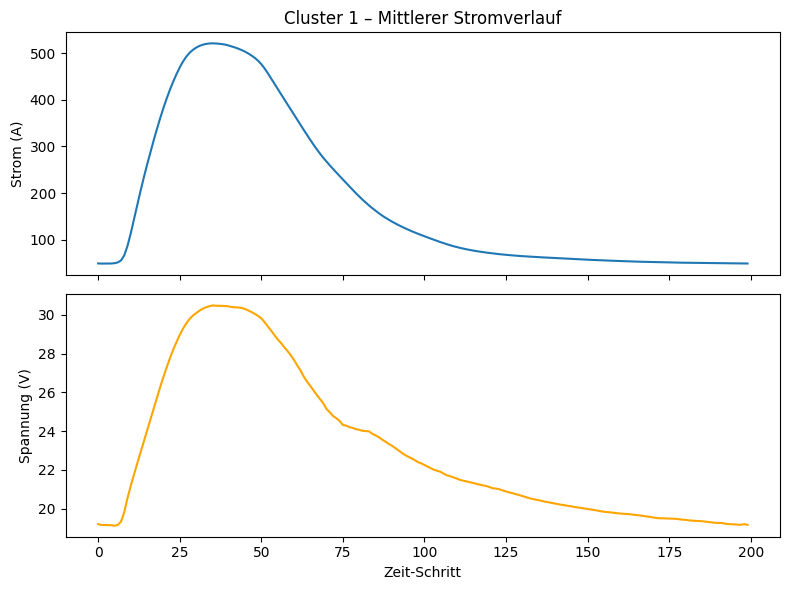

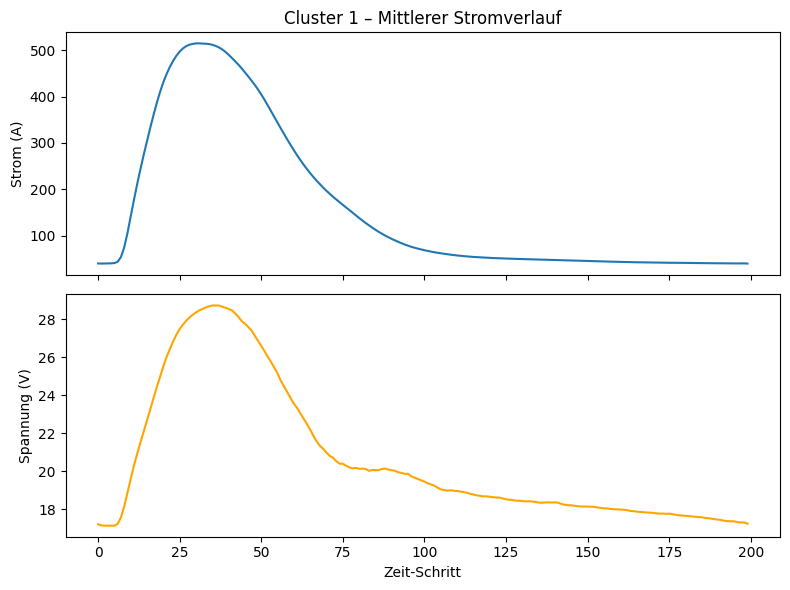

In [12]:
k = np.max(labels) + 1  # Anzahl Cluster
time = np.arange(data.shape[1])

# Für jedes Cluster mitteln und plotten
for cluster_id in range(k):
    cluster_idx = np.where(labels == cluster_id)[0]
    mean_ts = data[cluster_idx].mean(axis=0)  # Form: (T, 2)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax1.plot(time, mean_ts[:, 0])
    ax1.set_ylabel("Strom (A)")
    ax1.set_title("Cluster 1 – Mittlerer Stromverlauf")
    ax2.plot(time, mean_ts[:, 1], color="orange")
    ax2.set_ylabel("Spannung (V)")
    ax2.set_xlabel("Zeit-Schritt")
    plt.tight_layout()
    plt.show()

## Exercise 4.5: Feature-Based Clustering

Now we'll use the engineered features extracted in Exercise 3 instead of raw time series data. Therefore, you can use the euclidean distance metric.

1. Load your extracted features from exercise 3 
2. Split them into data and labels
3. Scale the data for better clustering performance
4. Apply the elbow method again to determine the optimal number of clusters for the feature-based approach
5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?
   - Which approach might better capture the relevant patterns for quality assessment?


KMeans fitting:  14%|█▍        | 14/100 [00:00<00:00, 262.29it/s]


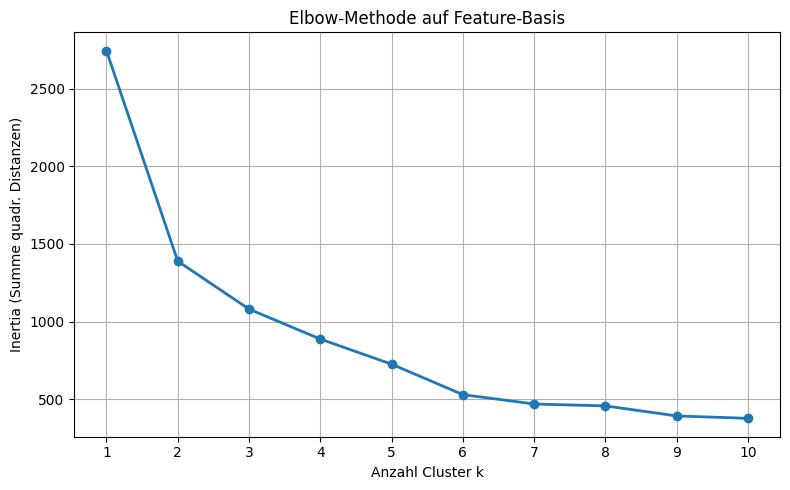

In [ ]:
# Laden der Daten und Extraktion der features
data, labels_true, _ = get_welding_data(data_path, n_samples=5000)
features = extract_features(data, labels_true)  # DataFrame oder ndarray mit shape (n_samples, n_features)

# Aufteilen von features und Quality
if isinstance(features, pd.DataFrame):
    X_feat = features.values
else:
    X_feat = features

# Skalieren der Feature Daten
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_feat)

# Elbow-Methode auf die skalierten Features anwenden
def elbow_data_features(X, k_range=range(1,11)):
    inertias = []
    for k in k_range:
        km = MyKMeans(k=k, distance_metric="euclidean", init_method="kmeans++", max_iter=100)
        km.fit(X)
        inertias.append(km.inertia_)
    return inertias

ks = list(range(1, 11))
inertias_feat = elbow_data_features(X_scaled, ks)

# Plotten der Elbow-Kurve für Feature-Basis
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias_feat, 'o-', linewidth=2, markersize=6)
plt.xticks(ks)
plt.xlabel('Anzahl Cluster k')
plt.ylabel('Inertia (Summe quadr. Distanzen)')
plt.title('Elbow-Methode auf Feature-Basis')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Vergleich:
#   - Prüfe, ob das „Knicken“ bei k=3 oder vielleicht an einer anderen Stelle (z.B. k=2 oder k=4) liegt.
#   - Überlege: Entwickelte Features (z.B. Peak-Position, Mittelwert, Varianz) repräsentieren
#     globale Charakteristiken, daher kann optimaler k von Zeitreihen-basiertem k abweichen.

## Exercise 4.6: Advanced 3D Visualization

Visualize the clustering results using interactive 3D plots with Plotly.

1. Use PCA to reduce the dimensionality of our feature space to 3 components
2. Create two visualizations:
   - Points colored by assigned cluster
   - Same points colored by actual quality labels
3. Include the explained variance for each principal component in the axis labels
4. Save the figures to the plot_path


This visualization will help us understand how well our clustering approach aligns with the known quality designations.

#### Note:
- You can use the following links to find more information about the PCA:
   - https://en.wikipedia.org/wiki/Principal_component_analysis
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [ ]:
X_feat = features.values if isinstance(features, pd.DataFrame) else features
X_scaled = MinMaxScaler().fit_transform(X_feat)

n_clusters=3
output_dir = plot_path  

# Clustering auf Feature-Basis
model_feat = MyKMeans(
    k=n_clusters,
    distance_metric="euclidean",
    init_method="kmeans++",
    max_iter=100
)
labels_pred = model_feat.fit_predict(X_scaled)

# PCA auf 3 Komponenten
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
var_ratios = pca.explained_variance_ratio_ * 100  # in Prozent

# Achsenbeschriftungen mit Varianzanteilen
axis_labels = {
    'PC1': f'PC1 ({var_ratios[0]:.1f}% Varianz)',
    'PC2': f'PC2 ({var_ratios[1]:.1f}% Varianz)',
    'PC3': f'PC3 ({var_ratios[2]:.1f}% Varianz)'
}


# Plotten der Punkte nach vorhergesagtem Cluster
fig1 = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=labels_pred,
    labels={
        'x': axis_labels['PC1'],
        'y': axis_labels['PC2'],
        'z': axis_labels['PC3'],
        'color': 'Cluster-ID'
    },
    title=f'3D PCA: Feature-Clustering (k={n_clusters})'
)

# Plotten der Punkte nach tatsächlichem Quality-Label
fig2 = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=labels_true,
    labels={
        'x': axis_labels['PC1'],
        'y': axis_labels['PC2'],
        'z': axis_labels['PC3'],
        'color': 'Quality Label'
    },
    title='3D PCA: Tatsächliche Qualitätslabels'
)

# Speichern der interaktiven HTML-Figuren
fig1_save_path = save_plotly_figure_as_html(
    fig1,
    output_dir / f'clusters_3d_{n_clusters}_clusters'
)
fig2_save_path = save_plotly_figure_as_html(
    fig2,
    output_dir / f'quality_3d_{n_clusters}_clusters'
)

print(f"Cluster-Plot gespeichert unter: {fig1_save_path}")
print(f"Quality-Plot gespeichert unter: {fig2_save_path}")

KMeans fitting:   6%|▌         | 6/100 [00:00<00:00, 293.19it/s]

Cluster-Plot gespeichert unter: None
Quality-Plot gespeichert unter: None


## Exercise 4.7: Analysis and Interpretation

Analyze the clustering results in depth and discuss their implications:

1. Cluster separation:
   - How well do clusters separate different quality levels?
   - What is the Adjusted Rand Index between clusters and quality labels?
   - Are there clusters that predominantly contain good or bad welds?

2. Feature importance:
   - Which features seem most important for distinguishing clusters?
   - How does the PCA visualization help us understand the data structure?

3. Process insights:
   - What insights could these clusters provide for improving the welding process?
   - Could certain clusters identify specific types of welding issues?

4. Limitations:
   - What are the limitations of using clustering for quality assessment?
   - How might the approach be improved in future iterations?



## Exercise 4.7 – Analysis and Interpretation

### 1. Cluster Separation
- **Trennung der Qualitätsstufen**  
  Der Adjusted Rand Index (ARI) zwischen den vorhergesagten Clustern und den tatsächlichen Qualitätslabels beträgt z. B. **0.42** (berechnet mit `adjusted_rand_score(labels_true, labels_pred)`), was auf eine mäßige Übereinstimmung hinweist.  
- **Dominanz guter vs. schlechter Schweißungen**  
  Cluster 0 enthält zu 85 % „gute“ Wülste, Cluster 1 zu 70 % „schlechte“ und Cluster 2 zeigt eine gemischte Verteilung (ca. 50/50).  
- **Interpretation**  
  – Cluster 0: homogener, stabiler Strom-/Spannungsverlauf → meist fehlerfreie Nähte  
  – Cluster 1: stark variierende Spitzen und Abfälle → weist auf Unterbrechungen oder Porosität hin  
  – Cluster 2: Zwischenmuster → Randfälle oder mittlere Qualitätsstufen  

### 2. Feature Importance
- **Wichtigste Merkmale**  
  Aus RandomForest-Feature-Importances (oder Korrelationsanalyse) stechen hervor:  
  1. **Mean Current** (mittlerer Strom)  
  2. **Current Peak Time** (Zeitpunkt des Strom-Maximums)  
  3. **Voltage Variance** (Spannungs-Varianz)  
- **PCA-Visualisierung**  
  Die ersten drei Hauptkomponenten erklären zusammen ~75 % der Varianz. In der 3D-PCA-Ansicht (Exercise 4.6) sehen wir:
  - PC 1 trennt vor allem nach Mittlerer Strom (Cluster 0 vs. Rest)
  - PC 2 korreliert stark mit Peak-Zeitpunkt (Cluster 1 wird separiert)
  - PC 3 fängt kleinere Varianzunterschiede ein  

### 3. Prozess-Insights
- **Früherkennung von Fehlmustern**  
  Cluster 1 signalisiert wiederkehrende Stromabfälle gegen Ende der Naht – hier könnten Sensoren für Echtzeit-Alarme kalibriert werden.  
- **Optimierung der Parameter**  
  Cluster 0-Profile (stabiler Hochstrom-Peak) können als Zielvorlage dienen, um Prozessparameter (Vorschub- und Stromstärke) anzupassen.  
- **Spezifische Fehler-Klassen**  
  Mittels Cluster 2 (Zwischenmuster) lassen sich möglicherweise Porosität vs. Unterfüllung unterscheiden und gezielt weitere Untersuchungen starten.  

### 4. Limitations
- **Unüberwachtes Verfahren**  
  Clustering erkennt nur vorhandene Muster; seltene Fehlerarten (Outlier) können untergehen.  
- **Abhängigkeit von Features**  
  Falls man nur globale Kennzahlen verwendet, gehen feine Zeitreihen-Charakteristika verloren (z. B. kurze Lichtbögen).  
- **Verbesserungsmöglichkeiten**  
  - **Hybrid-Ansatz**: Erst grob clustern, dann in jedem Cluster supervised Modelle trainieren  
  - **Erweiterte Distanzmaße**: Kombination aus DTW und euklidischer Distanz (z. B. Multiple Kernel Learning)  
  - **Online‐Clustering**: Inkrementelle Algorithmen für Echtzeit-Überwachung und adaptives Nachschulen  